In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_798.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_2592.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_318.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_207.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_2248.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_2733.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_2791.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_2393.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_106.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_2986.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_707.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_756.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Demented/non_1199.jpg
/kaggle/input/augmented-dataset/augmented_data/Non_Dement

# Imports

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
# noinspection PyUnresolvedReferences
import tensorflow.keras as tk
# noinspection PyUnresolvedReferences
import tensorflow.keras.layers as l
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# noinspection PyUnresolvedReferences
from tensorflow.keras.backend import clear_session
# noinspection PyUnresolvedReferences
from tensorflow.keras.models import clone_model
# noinspection PyUnresolvedReferences
from tensorflow.keras.utils import to_categorical

# early Stopping

In [56]:
# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Pretraitement

In [57]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "/kaggle/input/augmented-dataset/augmented_data"

##  Name of classes
CLASSES = ['Mild_Demented',
           'Moderate_Demented',
           'Non_Demented',
           'Very_Mild_Demented']

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator for loading and augmenting images
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(150, 150), batch_size=64)

# Initialize empty lists to store batches of data
X_batches = []
y_batches = []

# Iterate over the dataset generator to get batches of data
for i in range(len(train_dataset)):
    X_batch, y_batch = train_dataset[i]
    X_batches.append(X_batch)
    y_batches.append(y_batch)

# Concatenate batches to get the entire dataset
X = np.concatenate(X_batches, axis=0)
y = np.concatenate(y_batches, axis=0)

# Check the class indices
print(train_dataset.class_indices)




Found 13623 images belonging to 4 classes.
{'Mild_Demented_augmented': 0, 'Moderate_Demented_augmented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}


# Spliting Dagtaset

In [59]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 2935), (1, 2751), (2, 2263), (3, 1587)]
Validation	 [(0, 1007), (1, 977), (2, 751), (3, 534)]
Test      	 [(0, 253), (1, 260), (2, 186), (3, 119)]


In [60]:
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

#   class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 4195), (1, 3988), (2, 3200), (3, 2240)]
Classes Names according to index:	 {'Mild_Demented_augmented': 0, 'Moderate_Demented_augmented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}


In [61]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9536, 150, 150, 3)
y_train shape: (9536, 4)
X_test shape: (818, 150, 150, 3)
y_test shape: (818, 4)


# BI-LSTM TRAINING

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Reshape, LSTM, Bidirectional, Dropout, Dense, Input
from tensorflow.keras.optimizers import SGD

def build_model(num_classes):
    input_layer = Input(shape=(150, 150, 3))
    model = Sequential([
        input_layer,
        Conv2D(32, kernel_size=5, strides=2, activation="relu"),
        BatchNormalization(),
        Conv2D(64, kernel_size=5, strides=2, activation="relu"),
        BatchNormalization(),
        Conv2D(128, kernel_size=3, strides=2, activation="relu"),
        BatchNormalization(),
        Flatten(),  # Flatten the output of convolutional layers
        Reshape((17, 17*128)),  # Reshape to 3D tensor
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(128)),
        Dropout(0.2),
        Dense(num_classes, activation="softmax")
    ])
    optimizer = SGD(learning_rate=1e-2, clipnorm=1.)
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model


In [63]:
from keras.optimizers import SGD
num_classes=4
bi_lstm_model = build_model(num_classes)

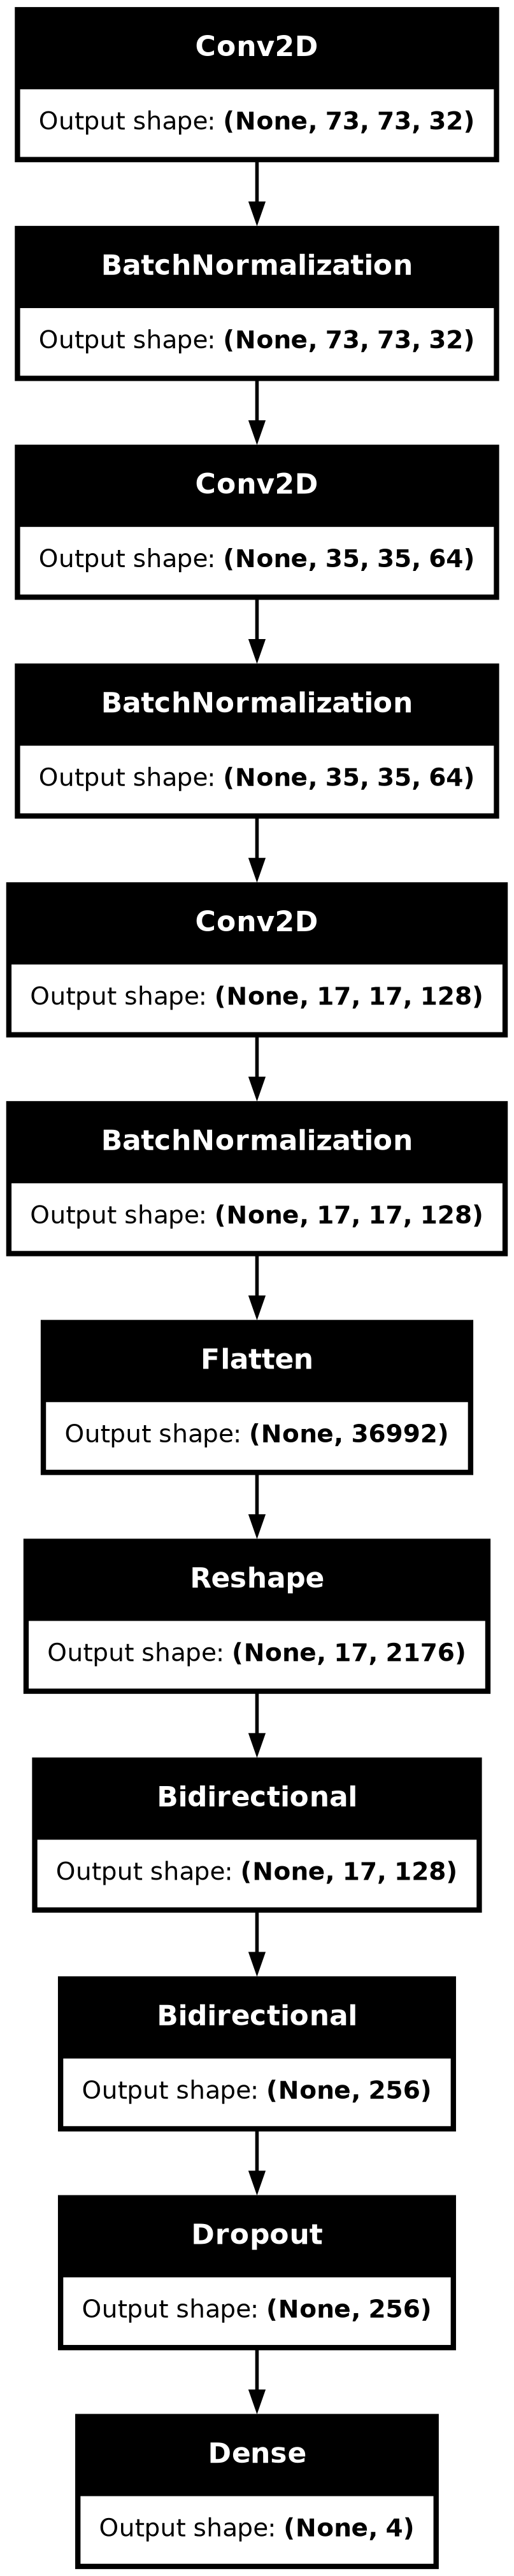

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
plot_model(bi_lstm_model, to_file='BiLstm_model.png', show_shapes=True)

In [65]:
bi_lstm_history = bi_lstm_model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 137s 442ms/step - accuracy: 0.4983 - loss: 1.0552 - val_accuracy: 0.4270 - val_loss: 1.1636
Epoch 2/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 139s 432ms/step - accuracy: 0.6249 - loss: 0.6736 - val_accuracy: 0.5714 - val_loss: 0.7034
Epoch 3/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 130s 435ms/step - accuracy: 0.6951 - loss: 0.6028 - val_accuracy: 0.7369 - val_loss: 0.5700
Epoch 4/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 141s 431ms/step - accuracy: 0.7662 - loss: 0.5122 - val_accuracy: 0.7825 - val_loss: 0.4754
Epoch 5/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 128s 431ms/step - accuracy: 0.8213 - loss: 0.4143 - val_accuracy: 0.6831 - val_loss: 0.5883
Epoch 6/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 140s 424ms/step - accuracy: 0.8521 - loss: 0.3471 - val_accuracy: 0.7222 - val_loss: 0.5671
Epoch 7/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 127s 426ms/step - accuracy: 0.8839 - loss: 0.2889 - val_accuracy: 0.7819 - val_loss: 0.4683
Epoch 8/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 141s 425ms/step - accuracy: 0.9149 -

# Bi_LSTM evaluation

In [66]:
from sklearn.metrics import classification_report

# Make predictions on the validation data
y_pred = bi_lstm_model.predict(X_val)

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels)

print(report)

103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1007
           1       0.93      0.95      0.94       977
           2       0.97      0.97      0.97       751
           3       0.95      0.95      0.95       534

    accuracy                           0.95      3269
   macro avg       0.95      0.95      0.95      3269
weighted avg       0.95      0.95      0.95      3269



In [67]:

bi_lstm_test_loss, bi_lstm_test_accuracy = bi_lstm_model.evaluate(X_test, y_test)
print(f"Bi_Lstm Test Accuracy: {bi_lstm_test_accuracy}, Test Loss: {bi_lstm_test_loss}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9638 - loss: 0.1169
Bi_Lstm Test Accuracy: 0.9547677040100098, Test Loss: 0.15651075541973114


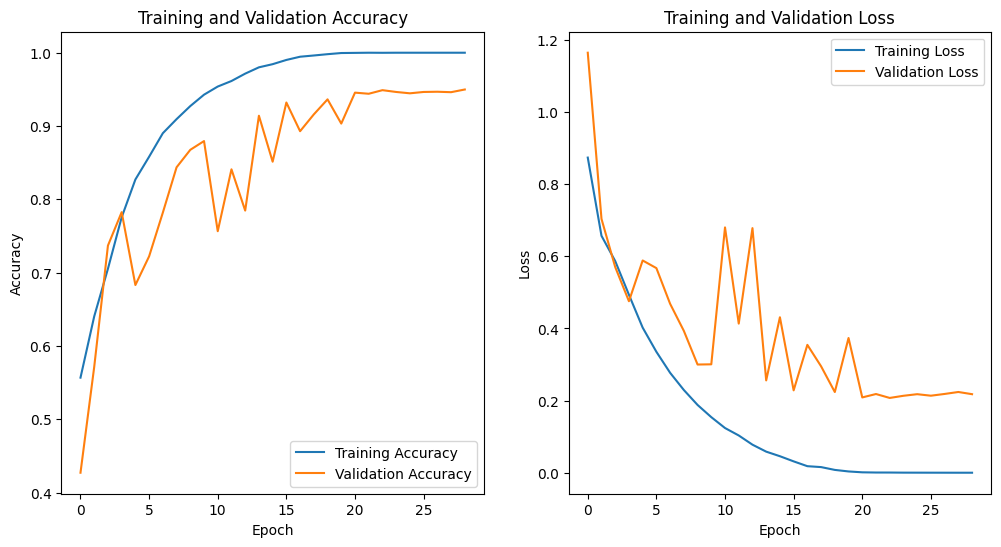

In [68]:
# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(bi_lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(bi_lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(bi_lstm_history.history['loss'], label='Training Loss')
plt.plot(bi_lstm_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [69]:

bi_lstm_model.save('/kaggle/working/modelBiLstm.keras')